<a href="https://colab.research.google.com/github/chaurasiauttkarsh/Machine-Learning/blob/master/8_Algorithm_Chains_and_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Most machine learning applications require not only the application of a single algorithm, but the chaining together of many different processing steps and machine learning models. We will cover how to use the Pipeline class to simplify the process of building chains of transformations and models. In particular, we will see how we can combine Pipeline and GridSearchCV to search over parameters for all processing steps at once.

As an example of the importance of chaining models, we noticed that we can greatly improve the performance of a kernel SVM on the cancer dataset by using the Min MaxScaler for preprocessing. Here’s code for splitting the data, computing the minimum and maximum, scaling the data, and training the SVM:

In [24]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


**Parameter Selection with Preprocessing**

In [25]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]} 
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


Here, we ran the grid search over the parameters of SVC using the scaled data. However, there is a subtle catch in what we just did. When scaling the data, we used all the data in the training set to compute the minimum and maximum of the data. We then use the scaled training data to run our grid search using cross-validation. For each split in the cross-validation, some part of the original training set will be declared the training part of the split, and some the test part of the split. The test part is used to measure the performance of a model trained on the training part when applied to new data. However, we already used the information contained in the test part of the split, when scaling the data. Remember that the test part in each split in the cross- validation is part of the training set, and we used the information from the entire training set to find the right scaling of the data. This is fundamentally different from how new data looks to the model. If we observe new data (say, in form of our test set), this data will not have been used to scale the training data, and it might have a different minimum and maximum than the training data.

In [26]:
!pip install mglearn
import mglearn

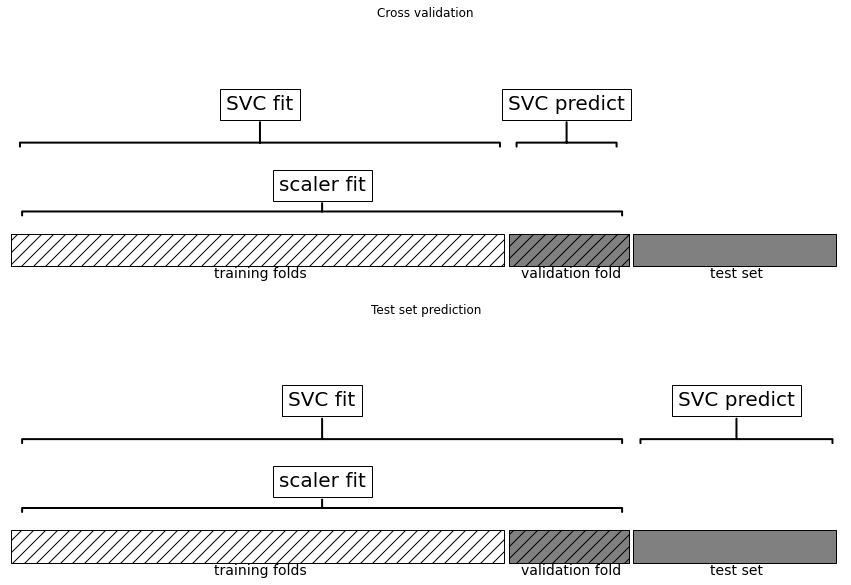

In [27]:
mglearn.plots.plot_improper_processing()

So, the splits in the cross-validation no longer correctly mirror how new data will look to the modeling process. We already leaked information from these parts of the data into our modeling process. This will lead to overly optimistic results during cross-validation, and possibly the selection of suboptimal parameters.

To get around this problem, the splitting of the dataset during cross-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be learned from the training portion of the dataset, and therefore be contained inside the cross-validation loop.

To achieve this in scikit-learn with the cross_val_score function and the Grid SearchCV function, we can use the Pipeline class. The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator. The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn.

**Building Pipelines**

Let’s look at how we can use the Pipeline class to express the workflow for training an SVM after scaling the data with MinMaxScaler (for now without the grid search). First, we build a pipeline object by providing it with a list of steps. Each step is a tuple containing a name (any string of your choosing) and an instance of an estimator:

In [0]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

Here, we created two steps: the first, called "scaler", is an instance of MinMaxScaler, and the second, called "svm", is an instance of SVC. Now, we can fit the pipeline, like any other scikit-learn estimator:

In [29]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVM with the scaled data. To evaluate on the test data, we simply call pipe.score:

In [30]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


Calling the score method on the pipeline first transforms the test data using the scaler, and then calls the score method on the SVM using the scaled test data. As you can see, the result is identical to the one we got from the code at the beginning of the chapter, when doing the transformations by hand. Using the pipeline, we reduced the code needed for our “preprocessing + classification” process. The main benefit of using the pipeline, however, is that we can now use this single estimator in cross_val_score or GridSearchCV.

**Using Pipelines in Grid Searches**

Using a pipeline in a grid search works the same way as using any other estimator. We define a parameter grid to search over, and construct a GridSearchCV from the pipeline and the parameter grid. When specifying the parameter grid, there is a slight change, though. We need to specify for each parameter which step of the pipeline it belongs to. Both parameters that we want to adjust, C and gamma, are parameters of SVC, the second step. We gave this step the name "svm". The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name. To search over the C parameter of SVC we therefore have to use "svm__C" as the key in the parameter grid dictio‐ nary, and similarly for gamma:

In [0]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

With this parameter grid we can use GridSearchCV as usual:

In [32]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5) 
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In contrast to the grid search we did before, now for each split in the cross-validation, the MinMaxScaler is refit with only the training splits and no information is leaked from the test split into the parameter search.

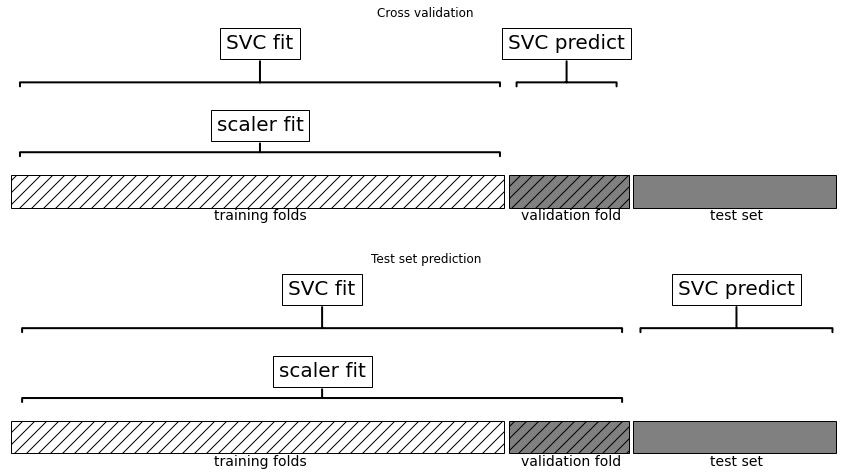

In [33]:
mglearn.plots.plot_proper_processing()

The impact of leaking information in the cross-validation varies depending on the nature of the preprocessing step. Estimating the scale of the data using the test fold usually doesn’t have a terrible impact, while using the test fold in feature extraction and feature selection can lead to substantial differences in outcomes.

**The General Pipeline Interface**

The Pipeline class is not restricted to preprocessing and classification, but can in fact join any number of estimators together. For example, you could build a pipeline containing feature extraction, feature selection, scaling, and classification, for a total of four steps. Similarly, the last step could be regression or clustering instead of classification.

The only requirement for estimators in a pipeline is that all but the last step need to have a transform method, so they can produce a new representation of the data that can be used in the next step.

Internally, during the call to Pipeline.fit, the pipeline calls fit and then transform on each step in turn,2 with the input given by the output of the transform method of the previous step. For the last step in the pipeline, just fit is called.

In [0]:
def fit(self, X, y):
  X_transformed = X
  for name, estimator in self.steps[:-1]:
    # iterate over all but the final step
    # fit and transform the data
    X_transformed = estimator.fit_transform(X_transformed, y)
        # fit the last step
  self.steps[-1][1].fit(X_transformed, y) 
  return self

In [0]:
def predict(self, X): 
  X_transformed = X
  for step in self.steps[:-1]:
    # iterate over all but the final step
    # transform the data
    X_transformed = step[1].transform(X_transformed)
    # predict using the last step
  return self.steps[-1][1].predict(X_transformed)

The pipeline is actually even more general than this. There is no requirement for the last step in a pipeline to have a predict function, and we could create a pipeline just containing, for example, a scaler and PCA. Then, because the last step (PCA) has a transform method, we could call transform on the pipeline to get the output of PCA.transform applied to the data that was processed by the previous step. The last step of a pipeline is only required to have a fit method.


**Convenient Pipeline Creation with make_pipeline**

Creating a pipeline using the syntax described earlier is sometimes a bit cumbersome, and we often don’t need user-specified names for each step. There is a convenience function, make_pipeline, that will create a pipeline for us and automatically name each step based on its class. The syntax for make_pipeline is as follows:

In [0]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))]) # abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

The pipeline objects pipe_long and pipe_short do exactly the same thing, but pipe_short has steps that were automatically named. We can see the names of the steps by looking at the steps attribute:

In [37]:
print("Pipeline steps:\n{}".format(pipe_short.steps)) 

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


The steps are named minmaxscaler and svc. In general, the step names are just lowercase versions of the class names. If multiple steps have the same class, a number is appended:

In [38]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler()) 
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


**Accessing Step Attributes**

Often you will want to inspect attributes of one of the steps of the pipeline—say, the coefficients of a linear model or the components extracted by PCA. The easiest way to access the steps in a pipeline is via the named_steps attribute, which is a dictionary from the step names to the estimators:

In [39]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step 
components = pipe.named_steps["pca"].components_ 
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


**Accessing Attributes in a Pipeline inside GridSearchCV**

Let’s grid search a LogisticRegression classifier on the cancer dataset, using Pipeline and StandardScaler to scale the data before passing it to the Logisti cRegression classifier. First we create a pipeline using the make_pipeline function:

In [0]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

Next, we create a parameter grid. The regularization parameter to tune for LogisticRegression is the parameter C. We use a logarithmic grid for this parameter, searching between 0.01 and 100. Because we used the make_pipeline function, the name of the LogisticRegression step in the pipeline is the lowercased class name, logisticregression. To tune the parameter C, we therefore have to specify a parameter grid for logisticregression__C:

In [0]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

As usual, we split the cancer dataset into training and test sets, and fit a grid search:

In [42]:
X_train, X_test, y_train, y_test = train_test_split( cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5) 
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

We know that the best model found by GridSearchCV, trained on all the training data, is stored in grid.best_estimator_:

In [43]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


This best_estimator_ in our case is a pipeline with two steps, standardscaler and logisticregression. To access the logisticregression step, we can use the named_steps attribute of the pipeline, as explained earlier:

In [44]:
print("Logistic regression step:\n{}".format( grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Now that we have the trained LogisticRegression instance, we can access the coefficients (weights) associated with each input feature:

In [45]:
print("Logistic regression coefficients:\n{}".format( grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


**Grid-Searching Preprocessing Steps and Model
Parameters**

We used polynomial features on the boston dataset before applying the ridge regressor. Let’s model that using a pipeline instead. The pipeline contains three steps—scaling the data, computing polynomial features, and ridge regression:

In [0]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

In [0]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge
pipe = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(),
        Ridge())

Using our pipeline, we can search over the degree parameter together with the parameter alpha of Ridge. To do this, we define a param_grid that contains both, appropriately prefixed by the step names:

In [0]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

Now we can run our grid search again:

In [51]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1) 
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                         

We can visualize the outcome of the cross-validation using a heat map.

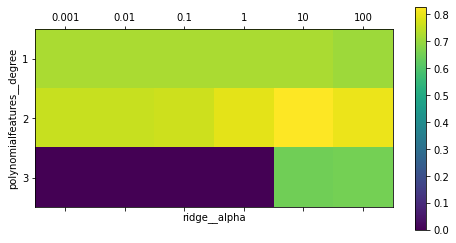

In [53]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha") 
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha']) 
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree']) 
plt.colorbar()

Looking at the results produced by the cross-validation, we can see that using polyno‐ mials of degree two helps, but that degree-three polynomials are much worse than either degree one or two. This is reflected in the best parameters that were found:

In [54]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


Which lead to the following score:

In [55]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


Let’s run a grid search without polynomial features for comparison:

In [56]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]} 
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5) 
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63
